In [1]:
pip install transformers

     |████████████████████████████████| 3.8 MB 14.3 MB/s 
     |████████████████████████████████| 77 kB 7.6 MB/s 
     |████████████████████████████████| 596 kB 75.7 MB/s 
     |████████████████████████████████| 895 kB 67.6 MB/s 
     |████████████████████████████████| 6.5 MB 56.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import transformers
from transformers import RobertaTokenizer
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler

**Load the training dataset**

In [3]:
dataset = pd.read_excel("/content/drive/MyDrive/Equintel_Uma/Data/training_dataset_67K.xlsx")
dataset = dataset.drop('Unnamed: 0', axis = 1)
dataset.shape

(17346, 2)

In [6]:
dataset[' sentiment'] = dataset[' sentiment'].apply(np.int64)
dataset.head()

,title,sentiment
0,Cloudberry Clean Energy AS ( OB: CLOUD-ME) acq...,1
1,Kuehne + Nagel International: +Nagel and SailG...,1
2,Time to start delivering low carbon projects a...,1
3,NYC Investment Firm Manager Accused Of Securit...,0
4,Canadian National Railway: CN Rail fined $ 100...,0


**Shuffle Dataframe before training**

In [7]:
def randomize(dataset):
    dataset_shuffled = dataset.sample(frac=1)
    return dataset_shuffled
    
for i in range(15):
    dataset=randomize(dataset)

print(dataset)

                                                   title   sentiment
10863  Tornado Alley isn't living up to its name with...           0
11881  Kessler Topaz Meltzer & Check, LLP: Reminds In...           0
11346  In numbers: Germany dominates European climate...           1
10408  Former TOWIE star Vas J Morgan claims castmate...           0
13245  Black Homeowners Face Discrimination in Apprai...           0
...                                                  ...         ...
2251   In new Facebook antitrust push, FTC says socia...           0
5563   Nest appoints Octopus Renewables to invest in ...           1
12257  Buy These Clean-Energy Stocks That Can Turn Fa...           1
2559   UK Antitrust Agency Again Assails Sports Store...           0
974    Pieridae Energy: Creating Caroline Carbon Capt...           1

[17346 rows x 2 columns]


In [8]:
train_texts = list(dataset['title'])
train_labels = list(dataset[' sentiment'])

Split into train and test 

In [9]:
train_texts, test_texts, train_labels, test_labels = train_test_split(train_texts, train_labels, test_size=.2)

Get the required Tokenizer

In [10]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', truncation=True)

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Tokenize the train and test texts and labels

In [11]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

In [12]:
import torch

class createDatasetObject(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)
#DatasetObjects are required for training the model
train_dataset = createDatasetObject(train_encodings, train_labels)
test_dataset = createDatasetObject(test_encodings, test_labels)

Import the RobertaSequenceClassification for training the model to perform sentiment analysis 

In [13]:
from transformers import RobertaForSequenceClassification, Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=16,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    learning_rate=5e-5,               # learning rate 
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=100,
)

model = RobertaForSequenceClassification.from_pretrained("siebert/sentiment-roberta-large-english",num_labels=2)

Downloading:   0%|          | 0.00/687 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32G [00:00<?, ?B/s]

Perform Training

In [14]:
trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=test_dataset             # evaluation dataset
)

trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 13876
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 2604


Step,Training Loss
100,0.048500
200,0.032000
300,0.034100
400,0.094300
500,0.070200
600,0.076100
700,0.075800
800,0.079400
900,0.084100
1000,0.752000


Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model weights saved in ./results/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-1500
Configuration saved in ./results/checkpoint-1500/config.json
Model weights saved in ./results/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-2000
Configuration saved in ./results/checkpoint-2000/config.json
Model weights saved in ./results/checkpoint-2000/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-2500
Configuration saved in ./results/checkpoint-2500/config.json
Model weights saved in ./results/checkpoint-2500/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=2604, training_loss=0.47689404580084044, metrics={'train_runtime': 2548.7664, 'train_samples_per_second': 16.333, 'train_steps_per_second': 1.022, 'total_flos': 7349727661882704.0, 'train_loss': 0.47689404580084044, 'epoch': 3.0})

In [15]:
trainer.evaluate(test_dataset)

***** Running Evaluation *****
  Num examples = 3470
  Batch size = 16


{'epoch': 3.0,
 'eval_loss': 0.43679168820381165,
 'eval_runtime': 64.8342,
 'eval_samples_per_second': 53.521,
 'eval_steps_per_second': 3.347}

In [16]:
trainer.predict(test_dataset)

***** Running Prediction *****
  Num examples = 3470
  Batch size = 16


PredictionOutput(predictions=array([[ 0.7636368 , -0.42287257],
       [ 0.76290417, -0.4255871 ],
       [ 0.76304   , -0.42574868],
       ...,
       [ 0.7633184 , -0.42492637],
       [ 0.76365256, -0.42448774],
       [-0.21584167,  0.0154602 ]], dtype=float32), label_ids=array([0, 0, 0, ..., 0, 0, 1]), metrics={'test_loss': 0.43679168820381165, 'test_runtime': 65.1677, 'test_samples_per_second': 53.247, 'test_steps_per_second': 3.33})

In [17]:
output=trainer.predict(test_dataset)[1]

***** Running Prediction *****
  Num examples = 3470
  Batch size = 16


In [18]:
#to find number of positives in the output
count=0
for i in output: 
  if (i == 1):    
    count+=1
print(count)

1748


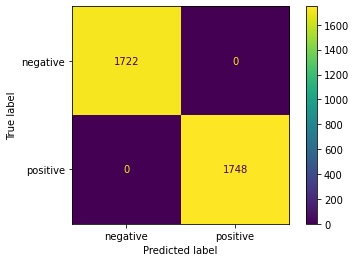

In [19]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

cm=confusion_matrix(test_labels,output)
cmd = ConfusionMatrixDisplay(cm, display_labels=['negative','positive'])
cmd.plot()

In [20]:
print(test_labels[-10:-1])
print(output[-10:-1])

[0, 1, 1, 1, 1, 0, 1, 0, 0]
[0 1 1 1 1 0 1 0 0]


In [21]:
trainer.save_model('/content/drive/MyDrive/Equintel_Uma/Trained_Models/senti-model-05_04_22')
#model.save_pretrained('/content/drive/MyDrive/Equintel_Uma/Trained_Models/senti-model-new')
tokenizer.save_pretrained('/content/drive/MyDrive/Equintel_Uma/Trained_Models/senti-model-05_04_22')

Saving model checkpoint to /content/drive/MyDrive/Equintel_Uma/Trained_Models/senti-model-05_04_22
Configuration saved in /content/drive/MyDrive/Equintel_Uma/Trained_Models/senti-model-05_04_22/config.json
Model weights saved in /content/drive/MyDrive/Equintel_Uma/Trained_Models/senti-model-05_04_22/pytorch_model.bin
tokenizer config file saved in /content/drive/MyDrive/Equintel_Uma/Trained_Models/senti-model-05_04_22/tokenizer_config.json
Special tokens file saved in /content/drive/MyDrive/Equintel_Uma/Trained_Models/senti-model-05_04_22/special_tokens_map.json


('/content/drive/MyDrive/Equintel_Uma/Trained_Models/senti-model-05_04_22/tokenizer_config.json',
 '/content/drive/MyDrive/Equintel_Uma/Trained_Models/senti-model-05_04_22/special_tokens_map.json',
 '/content/drive/MyDrive/Equintel_Uma/Trained_Models/senti-model-05_04_22/vocab.json',
 '/content/drive/MyDrive/Equintel_Uma/Trained_Models/senti-model-05_04_22/merges.txt',
 '/content/drive/MyDrive/Equintel_Uma/Trained_Models/senti-model-05_04_22/added_tokens.json')

# Validate using the Trainer Object 

In [22]:
val_dataset = pd.read_excel("/content/drive/MyDrive/Equintel_Uma/Data/Validation_dataset_67K.xlsx")
val_dataset = val_dataset.drop('Unnamed: 0', axis = 1)
val_dataset.shape

(1927, 2)

In [23]:
val_dataset[' sentiment'] = val_dataset[' sentiment'].apply(np.int64)
val_dataset.head()

,title,sentiment
0,Cloudberry Clean Energy AS ( OB: CLOUD-ME) acq...,1
1,NSW Aims for Renewable Energy Superpower Statu...,1
2,Intelligence bulletin warns Russia amplifying ...,0
3,Recycling And Waste Solutions Company PreZero ...,1
4,Biden Benefits Galore For This Renewable Energ...,1


In [24]:
val_texts = list(val_dataset['title'])
val_labels = list(val_dataset[' sentiment'])

In [25]:
val_encodings = tokenizer(val_texts, truncation=True, padding=True)
validation_dataset = createDatasetObject(val_encodings, val_labels)

In [26]:
#Validation using the Trainer Object
output=trainer.predict(validation_dataset)[1]

***** Running Prediction *****
  Num examples = 1927
  Batch size = 16


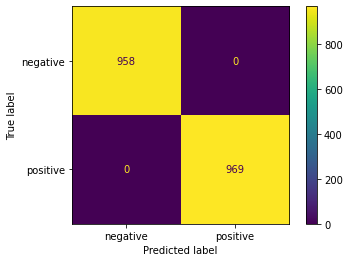

In [27]:
cm=confusion_matrix(val_labels,output)
cmd = ConfusionMatrixDisplay(cm, display_labels=['negative','positive'])
cmd.plot()